# Transformation to UFL Code (Medium)

In [1]:
import ufl
ufl_map = {
    "math.exp": ufl.exp,
    "math.log": ufl.ln,
    "math.sin": ufl.sin,
    "math.cos": ufl.cos,
    "math.tan": ufl.tan,
    "sqrt": ufl.sqrt,
    "ImmutableDenseMatrix": ufl.as_vector,
}

In [2]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
from sympy.utilities.lambdify import lambdify


from library.fvm.solver import Settings
from library.model.models.shallow_water import ShallowWaterEquations


import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.misc.misc import Zstruct
import library.transformation.to_ufl as trafo

2025-08-19 15:56:24.625 | WARNING  | library.fvm.solver:<module>:28 - No module named 'precice'


In [3]:
bcs = BC.BoundaryConditions(
    [
        BC.Wall(physical_tag="top"),
        BC.Wall(physical_tag="bottom"),
        BC.Wall(physical_tag="left"),
        BC.Wall(physical_tag="right"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowWaterEquations(
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)



In [4]:
import os
from mpi4py import MPI
import numpy as np
import dolfinx
from dolfinx import fem
import basix
import tqdm
from petsc4py import PETSc
import numpy as np
import ufl
import pyvista
from  dolfinx.fem import petsc
import sys
from dolfinx import mesh

In [5]:
def create_domain(Nx, Ny, P0=[0, 0], P1=[3, 3]):
    """
    Create a rectangular mesh domain with N elements in each direction.
    """

    number_elements_x = Nx
    number_elements_y = Ny

    domain = mesh.create_rectangle(
        MPI.COMM_WORLD, [P0, P1], [number_elements_y, number_elements_y], cell_type=mesh.CellType.quadrilateral
    )

    reference_edge_length = (P1[0]-P0[0])/number_elements_x
    return domain, reference_edge_length, P0, P1

## Imports

In [6]:
def create_function_space(domain):
    mesh_element_name = domain.topology.cell_name()  
    """ type of mesh basix.ufl.element, e.g. "quadrilateral" """


    elem_Q = basix.ufl.element("DG", domain.topology.cell_name(), 0, shape=(3,))
    space_Q = fem.functionspace(domain, elem_Q)
    return space_Q


In [7]:
shape_factor = 1

In [8]:
import sympy

In [9]:
fx = model.flux()[0].subs(model.parameters.g, 9.81)
fy = model.flux()[1].subs(model.parameters.g, 9.81)
f = sympy.Matrix([list(fx), list(fy)]).T
f.shape


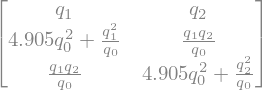

In [10]:
f

In [ ]:
def get_primitives(Q):
    eps = 10**(-6)
    h = Q[0]
    h = ufl.conditional(h > 0, h, 0) 
    h_inv = (ufl.sqrt(2.) * h)/(ufl.sqrt(h**4 + ufl.conditional(h**4 > eps, h**4, eps)))
    u = Q[1]*h_inv
    v = Q[2]*h_inv
    return h, u, v



# def flux(Q):
#     h, u, v = get_primitives(Q)
#     return ufl.as_tensor([[h*u, h*v],
#                           [shape_factor*h*u*u + 9.81*h*h/2, shape_factor*h*u*v],
#                           [shape_factor*h*u*v, shape_factor*h*v*v + 9.81*h*h/2]
# ])

flux = lambdify(
        (
            model.variables.get_list(),
        ),
        f,
        ufl_map,
    )


    
#################TODO#################################
def source(Q, db_dx, db_dy):
    h, u, v= get_primitives(Q)
    return ufl.as_vector([0, 0, 0])
######################################################

#################TODO#################################
def max_abs_eigenvalue(Q, n):
    gz = 9.81
    h, u, v= get_primitives(Q)
    return shape_factor*abs(ufl.dot(ufl.as_vector([u, v]), n)) + ufl.sqrt(gz * h) 
######################################################


#################TODO#################################
I = ufl.as_tensor([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
######################################################

def numerical_flux(Ql, Qr, n):
    return ufl.dot(0.5 *(flux(Ql)+ flux(Qr)), n)- 0.5 * 0.5*(max_abs_eigenvalue(Ql, n) + max_abs_eigenvalue(Qr, n) )* I * (Qr- Ql)

def extract_scalar_fields(Q):
    q0 = Q.sub(0).collapse()
    q0.x.array[q0.x.array < 1e-12] = 0.
    q0.name = "h" 
    q1 = Q.sub(1).collapse()
    q1.name = "hu" 
    q2 = Q.sub(2).collapse()
    q2.name = "hv" 
    return [q0, q1, q2]

def compute_time_step_size(Q, reference_cell_diameter, CFL=0.45):
    [h, hu, hv] = extract_scalar_fields(Q)
    h = h.x.array
    h = np.where(h > 0., h, 0) 
    eps = 10**(-6)
    h_inv = (np.sqrt(2.) * h)/(np.sqrt(h**4 + np.max([np.ones_like(h) * eps, h**4], axis=0)))
    u = hu.x.array * h_inv
    v = hv.x.array * h_inv
    # Compute local max eigenvalues array
    local_max_eigenvalue = max(np.max(shape_factor.value*np.abs(u) + np.sqrt(gz.value * h)), np.max(shape_factor.value*np.abs(v) + np.sqrt(gz.value * h)))

    # Global maximum reduction across all ranks
    global_max_eigenvalue = MPI.COMM_WORLD.allreduce( local_max_eigenvalue, op=MPI.MAX)
    
    dt = CFL * reference_cell_diameter / global_max_eigenvalue
    
    if np.isnan(dt) or np.isinf(dt) or dt < 10**(-6):
        dt = 10**(-6)

    return dt

In [12]:
import os
from ufl import (
    TestFunction,
    TrialFunction,
    dx,
    inner,
    inner,
)
import pyvista
import dolfinx
from dolfinx.fem import Function
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import locate_entities_boundary, meshtags
import numpy as np

In [13]:

def extract_scalar_fields(Q):
    q0 = Q.sub(0).collapse()
    q0.x.array[q0.x.array < 1e-12] = 0.
    q0.name = "h" 
    q1 = Q.sub(1).collapse()
    q1.name = "hu" 
    q2 = Q.sub(2).collapse()
    q2.name = "hv" 
    return [q0, q1, q2]



def make_unique_dir(base_path):
    """
    Create a unique directory. If `base_path` exists, appends _1, _2, ... until an unused path is found.

    Returns the final created path.
    """
    dir_path = base_path
    counter = 1

    while os.path.exists(dir_path):
        dir_path = f"{base_path}_{counter}"
        counter += 1

    os.makedirs(dir_path)
    return dir_path

def project(scalarfield, space_CG):
    field = scalarfield.copy()
    w = TrialFunction(space_CG)
    phi = TestFunction(space_CG)
    
    a = inner(w, phi) * dx 
    L = inner(field, phi) * dx 
    
    problem = LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    field_proj = problem.solve()
    
    return field_proj

def extract_values(q, *args):
    Q = q.function_space
    if len(args) == 0:
        dof_map = Q.dofmap.list.flatten()
        return q.x.array[dof_map]
    elif len(args) == 1:
        i = args[0]
        dof_map = Q.sub(i).dofmap.list.flatten()
        return q.sub(i).x.array[dof_map]
    elif len(args) == 2:
        i = args[0]
        j = args[1]
        dof_map = Q.sub(i).sub(j).dofmap.list.flatten()
        return q.sub(i).x.array[dof_map]
    else:
        assert False
        

def generate_facets_tags(domain, P0, P1):
    """
    Generate facet tags for the boundary of the mesh.
    """
    # Get the mesh topology dimension and facet geometrical dimension
    mesh_topology_dim = domain.topology.dim
    facet_geometrical_dimension = mesh_topology_dim - 1
    fdim = facet_geometrical_dimension
    if mesh_topology_dim == 2:
        left = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[0], P0[0]))
        right = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[0], P1[0]))
        bottom = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[1], P0[1]))
        top = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[1], P1[1]))
        
        facets = np.concatenate([left, right, bottom, top])
        values = np.concatenate([
            np.full_like(left, 1),
            np.full_like(right, 2),
            np.full_like(bottom, 3),
            np.full_like(top, 4),
        ])
    elif mesh_topology_dim == 3:
        left = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[0], P0[0]))
        right = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[0], P1[0]))
        front = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[1], P0[1]))
        back = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[1], P1[1]))
        bottom = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], P0[2]))
        top = locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], P1[2]))
        
        facets = np.concatenate([left, right, front, back, bottom, top])
        values = np.concatenate([
            np.full_like(left, 1),
            np.full_like(right, 2),
            np.full_like(front, 3),
            np.full_like(back, 4),
            np.full_like(bottom, 5),
            np.full_like(top, 6),
        ])
    else: 
        assert False
            
        


    sorted_facets = np.argsort(facets)
    facet_tags = meshtags(domain, fdim, facets[sorted_facets], values[sorted_facets])
    return facet_tags
        
def setup_notebook_paths():
    try:
        CMM_DIR = os.getcwd()
        os.environ["PYTHONPATH"] = f"{CMM_DIR}:{os.environ.get('PYTHONPATH', '')}"
        username = os.getenv("USER") or os.geteuid()

        # Set XDG_RUNTIME_DIR to a valid directory
        os.environ["XDG_RUNTIME_DIR"] = f"/tmp/runtime-{username}"
        os.makedirs(os.environ["XDG_RUNTIME_DIR"], exist_ok=True)
        os.chmod(os.environ["XDG_RUNTIME_DIR"], 0o700)
    except Exception as e:
        print(f"Failed to set XDG_RUNTIME_DIR: {e}")
        print("You might get some warnings, but it should still work.")
        
    
def compute_max_deformation(function):

    # Extract the mesh from the function space
    functionspace = function.function_space
    mesh = functionspace.mesh

    # Convert the *original* mesh to PyVista
    cells, cell_types, coords = dolfinx.plot.vtk_mesh(mesh)
    original_grid = pyvista.UnstructuredGrid(cells, cell_types, coords)

    # Get the displacement array and reshape to (Npoints, geometry_dim)
    geometry_dim = mesh.geometry.dim
    num_points = coords.shape[0]
    displacement = function.x.array
    displacement_reshaped = displacement.reshape((num_points, geometry_dim))

    
     # max displacement
    max_displacement = np.max(np.abs(displacement_reshaped), axis=0)
    print(f"maximum displacement: {max_displacement}")
    return max_displacement


In [14]:
def weak_form_swe(functionspace, q_n, q_np, t, x, dt):
    # facet normals
    domain = functionspace.mesh
    n = ufl.FacetNormal(domain)

    # our integration measures over the inner boundaries, the domain boundaries and the whole domain. 
    # Note that we separate the domain boundaries in order to potentially apply different boundary conditions
    # on each side
    dS = ufl.Measure("dS", domain=domain)
    facet_tags = generate_facets_tags(domain, P0, P1)
    ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)
    dx = ufl.dx


    # implicit/explicit switch
    q = q_n
    # extrapolation boundary conditions
    q_extrapolation = q_n


    # We would like to have gradients of the bottom topography. However, DG0 is constant in each cell, resulting in zero gradients.
    # we help ourselves by projecting DG0 to a CG1 (linear continuous functions) space, where the gradients do exist.
    # note that this is a 'cheap trick'. In reality, the computation of the bottom topography gradient is critical and deserves
    # more attention.
    elem_CG1 = basix.ufl.element("CG", domain.topology.cell_name(), 1)
    space_CG1 = fem.functionspace(domain, elem_CG1)


    test_q = ufl.TestFunction(functionspace)
    trial_q = ufl.TrialFunction(functionspace)
    
    # weak formulation
    weak_form =  ufl.dot(test_q, (trial_q-q)/dt) * dx
    weak_form += ufl.dot((test_q("+") - test_q("-")), numerical_flux(q("+"), q("-"), n("+"))) * dS
    weak_form += ufl.dot((test_q), numerical_flux(q, q_extrapolation, n)) * (ds(1) + ds(2) + ds(3) + ds(4))
    
    #################TODO#################################
    weak_form += 0
    ######################################################


    weak_form_lhs = fem.form(ufl.lhs(weak_form))
    weak_form_rhs = fem.form(ufl.rhs(weak_form))

    return weak_form_lhs, weak_form_rhs

In [15]:
def prepare_solver(weak_form_lhs, weak_form_rhs):
    A = petsc.create_matrix(weak_form_lhs)
    b = petsc.create_vector(weak_form_rhs)

    solver = PETSc.KSP().create(MPI.COMM_WORLD)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.BCGS)
    preconditioner = solver.getPC()
    preconditioner.setType(PETSc.PC.Type.JACOBI)
    return solver, A, b

In [16]:
def solve_time_loop(name: str, weak_form_function, functionspace, initial_condition, end_time, output_path, CFL, reference_edge_length):
    
    domain = functionspace.mesh
    t = fem.Constant(domain, dolfinx.default_scalar_type(0.0))    
    
    # dt will be overwritten
    dt = fem.Constant(domain, dolfinx.default_scalar_type(0.1))    

    x = ufl.SpatialCoordinate(domain)
        
    q_n = fem.Function(functionspace, name=r'$q^n$')
    q_np1 = fem.Function(functionspace, name=r'$q^{n+1}$')
    
    q_n.interpolate(initial_condition)
    q_np1.interpolate(initial_condition)

    
    
    weak_form_lhs, weak_form_rhs = weak_form_function(functionspace, q_n, q_np1, t, x, dt)
    
    solver, A, b = prepare_solver(weak_form_lhs, weak_form_rhs)    
    A = petsc.create_matrix(weak_form_lhs)
    b = petsc.create_vector(weak_form_rhs)
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.BCGS)
    preconditioner = solver.getPC()
    preconditioner.setType(PETSc.PC.Type.JACOBI)

    num_timesteps = int(end_time/dt.value)
    
    # VTK writer
    os.makedirs(output_path, exist_ok=True)
    vtk_file_abs_path_name = os.path.join(output_path, f"{name}.pvd")
    vtk_writer = dolfinx.io.VTKFile(
        domain.comm, vtk_file_abs_path_name, "w+"
    )
    

    vtk_writer.write_function(extract_scalar_fields(q_n), t=0.0)
    n_snapshots = 50
    dt_snapshot = end_time / n_snapshots
    next_snapshot_time = dt_snapshot
    

    progress = tqdm.tqdm(desc="Setup " + name + ", solving PDE", total=end_time)

    max_timesteps = 10000
    i=0
    while t.value < end_time and i < max_timesteps:
        q_n.interpolate(q_np1)
        
        # time step size estimation
        dt.value  = compute_time_step_size(q_np1, reference_edge_length, CFL=CFL)
        progress.update(dt.value)


        A.zeroEntries()
        petsc.assemble_matrix(A,weak_form_lhs)
        A.assemble()
        with b.localForm() as loc:
            loc.set(0)
        petsc.assemble_vector(b,weak_form_rhs)

        b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver.solve(b, q_np1.x.petsc_vec)

        q_np1.x.scatter_forward()
        t.value += dt.value
        i += 1
        
        
        if t.value > next_snapshot_time:
            vtk_writer.write_function(extract_scalar_fields(q_np1), t=t.value)
            next_snapshot_time += dt_snapshot

    progress.close()
    return q_np1


In [17]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np

from library.fvm.solver import Settings
from library.model.models.shallow_water import ShallowWaterEquations

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.misc.misc import Zstruct
import library.transformation.to_ufl as trafo

In [18]:
output_dir = 'outputs/ufl'

In [19]:
 ### Initial condition
def ic_q(x):
    R = 0.15
    r = np.sqrt((x[0] - 0.7)**2 + (x[1] - 0.7)**2)
    b = 0.1*np.sqrt((x[0] - 3.)**2 + (x[1] - 3.)**2)
    return np.array([np.where(r <= R, 1., 0.9), 0.*x[0], 0.*x[0]])

### Mesh and function space creation
domain, reference_edge_length, P0, P1 = create_domain(100, 100)
space_Q = create_function_space(domain)

### Parameters
gx = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type(0))
gy = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type(0))
gz = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type(9.81))
friction_coeff = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type(0.))
shape_factor = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type(1.))


### Simulation
q_sol = solve_time_loop(name="sim0", weak_form_function=weak_form_swe, functionspace=space_Q, initial_condition=ic_q, end_time=1.0, output_path=os.path.join(output_dir, 'sim'), CFL=0.2, reference_edge_length=reference_edge_length)


Setup sim0, solving PDE: 100%|██████████| 1.0003758564788783/1.0 [00:13<00:00, 13.10s/it]  
